In [1]:
import os

if not os.path.exists('SUR_projekt2022-2023.zip'):
    !wget https://www.fit.vutbr.cz/study/courses/SUR/public/projekt_2022-2023/SUR_projekt2022-2023.zip
    !unzip SUR_projekt2022-2023.zip
if not os.path.exists('SUR_projekt2022-2023_eval.zip'):
    !wget https://www.fit.vutbr.cz/study/courses/SUR/public/projekt_2022-2023/SUR_projekt2022-2023_eval.zip
    !unzip SUR_projekt2022-2023_eval.zip

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from augment import augment_images
import os
import shutil

import ikrlib as ikrl


# Image
## CNN

In [3]:
data_augmentation_enabled = False


CLASSES = 31

#copy all to train
for cls in range(1, CLASSES + 1):
    for f in os.listdir(os.path.join("dev", str(cls))):
       shutil.copy(os.path.join("dev", str(cls), f), os.path.join("train", str(cls), f))


if data_augmentation_enabled:
    augment_images('train', 'train/da')
    augment_images('dev', 'dev/da')

In [4]:
from image import CustomDataset, CNNModel



train_x = np.empty((0, 80, 80, 3))
train_y = np.empty((0), dtype=int)

test_x = np.empty((0, 80, 80, 3))
test_y = np.empty((0), dtype=int)

for i in range(1, CLASSES + 1):
    train_i = np.array(list(ikrl.png_load(os.path.join("train", str(i)), False).values()))
    label_i = np.full(len(train_i), i - 1)
    train_x = np.concatenate((train_x, train_i), axis=0)
    train_y = np.concatenate((train_y, label_i), axis=0)

    test_i = np.array(list(ikrl.png_load(os.path.join("dev", str(i)), False).values()))
    label_i = np.full(len(test_i), i - 1)
    test_x = np.concatenate((test_x, test_i), axis=0)
    test_y = np.concatenate((test_y, label_i), axis=0)

print("Images were successfully loaded")

# convert 80,80,3 to 3,80,80
train_x = np.array(train_x)
train_x = np.transpose(train_x, (0, 3, 1, 2))

test_x = np.array(test_x)
test_x = np.transpose(test_x, (0, 3, 1, 2))

# Convert NumPy arrays to PyTorch tensors
train_tensors = torch.Tensor(train_x)
test_tensors = torch.Tensor(test_x)

# Create new TensorDataset instances with the modified labels
train_dataset = CustomDataset(train_tensors, train_y)
test_dataset = CustomDataset(test_tensors, test_y)
print("Dataset was successfully created")

model = CNNModel(num_classes=31, lr=1e-4)
model.train_net(train_dataset, test_dataset, num_epochs=100)
print("Model was successfully trained")


Images were successfully loaded
Dataset was successfully created
Epoch: 1/100, Loss: 115.0990, Accuracy: 0.0000, 0 and 62
Epoch: 51/100, Loss: 7.1101, Accuracy: 0.9839, 61 and 62
Epoch: 100/100, Loss: 1.4620, Accuracy: 0.9839, 61 and 62
Model was successfully trained


In [5]:
eval_data = np.array(list(ikrl.png_load('eval', False).values()))
eval_data = np.array(eval_data)
eval_data = np.transpose(eval_data, (0, 3, 1, 2))
eval_data = torch.Tensor(eval_data)

eval_dataset = CustomDataset(eval_data, np.zeros(len(eval_data)))

pred = model.predict(eval_dataset)

# Detach each tensor, convert it to a NumPy array, and stack them together
pred = np.stack([tensor.detach().numpy() for tensor in pred])

# First, apply the softmax function to convert values to probabilities
exp_matrix = np.exp(pred)
row_sums = exp_matrix.sum(axis=2, keepdims=True)

# Normalize each value by dividing it by the sum of the values in its row
cnn_predictions = exp_matrix / row_sums


# get a list of all files in the eval folder
file_list = os.listdir('eval')
from PIL import Image

with open('out_cnn_image.txt','w') as f:
    for file in file_list:
        if file.endswith(".png"):  # check if the file is a PNG file
            file_path = os.path.join('eval', file)  # get the full file path
            image = np.array(Image.open(file_path), dtype=np.float64)
            #transpose
            image = np.expand_dims(image, axis=0)
            image = np.transpose(image, (0, 3, 1, 2))

            tensor_image = torch.Tensor(image)
            eval_dataset = CustomDataset(tensor_image, np.zeros(len(tensor_image)))

            model.eval()
            with torch.no_grad():
                pred = model.predict(eval_dataset)

            # Detach
            pred = np.stack([tensor.detach().numpy() for tensor in pred])
            exp_m = np.exp(pred)
            row_sums = exp_m.sum(axis=2, keepdims=True)
            pred = exp_m / row_sums

            #format: file_name hard_decision soft_decision (31 values)
            f.write(file + ' ' + str(np.argmax(pred)+1) + ' ' + ' '.join(map(str, pred[0][0])) + '\n')


## SVM

In [13]:
from svm import SVCTrain

model = SVCTrain()
model.train_svc(train_dataset, eval_dataset)
svm_prob = model.predict_whole_dataset(eval_data)
print(model.predict_whole_dataset(eval_data))



with open('out_svm_image.txt','w') as f:
    for file in file_list:
        if file.endswith(".png"):  # check if the file is a PNG file
            file_path = os.path.join('eval', file)  # get the full file path
            image = np.array(Image.open(file_path), dtype=np.float64)
            #transpose
            image = np.expand_dims(image, axis=0)
            image = np.transpose(image, (0, 3, 1, 2))

            tensor_image = torch.Tensor(image)
            pred = model.predict_whole_dataset(tensor_image)

            #format: file_name hard_decision soft_decision (31 values)
            f.write(file + ' ' + str(np.argmax(pred)+1) + ' ' + ' '.join(map(str, pred[0])) + '\n')



[[0.03692547 0.06015949 0.01462083 ... 0.0024862  0.00287056 0.0063788 ]
 [0.05407894 0.01182673 0.03587151 ... 0.03511596 0.02109499 0.01256991]
 [0.00364623 0.00845596 0.0139231  ... 0.03372357 0.08654971 0.02703446]
 ...
 [0.00968261 0.02047737 0.44131811 ... 0.00961787 0.01049719 0.01169139]
 [0.44089958 0.02871456 0.01700998 ... 0.00487867 0.00520667 0.00461184]
 [0.00511753 0.0049935  0.00601107 ... 0.09500017 0.0257349  0.02510688]]


## GMM

Train dataset shape: (248, 6400)
Train all shape: (248, 6400)
Creating subs mean classes SVD
Training GMM
(31, 248) (31, 248)
31
Accuracy: 1.0


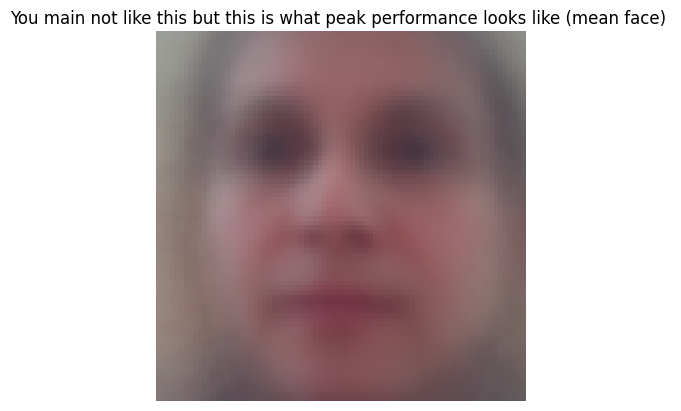

In [15]:
from gmm import GMMmodel

train_dataset_np = np.array(train_dataset.images)
train_dataset_mean_face = np.mean(train_dataset_np, axis=0)
plt.imshow(train_dataset_mean_face.transpose(1, 2, 0).astype(np.uint8))
plt.title("You main not like this but this is what peak performance looks like (mean face) ")
plt.axis('off')

model = GMMmodel()
eval_subs_mean = model.train_gmm(train_dataset, test_dataset, eval_dataset)





In [23]:
res = model.predict(eval_subs_mean[0])
res = res.T

# Subtract the maximum value from each row
res -= np.max(res, axis=1, keepdims=True)

# Calculate the exponentials
prob_matrix = np.exp(res)

# Normalize the probabilities so that they sum to 1 for each data point
gmm_image_prob = prob_matrix / prob_matrix.sum(axis=1, keepdims=True)

print("Normalized probability matrix:")
print(gmm_image_prob)


with open('out_gmm_image.txt','w') as f:
    for file in file_list:
        if file.endswith(".png"):  # check if the file is a PNG file
            file_path = os.path.join('eval', file)  # get the full file path
            image = np.array(Image.open(file_path), dtype=np.float64)
            #transpose
            image = np.expand_dims(image, axis=0)
            image = np.transpose(image, (0, 3, 1, 2))
            print(train_dataset_np.shape)
            print(image.shape)
            tensor_image = torch.Tensor(image)  # convert to tensor

            eval = model.predict(tensor_image)


            eval = eval.T
            eval -= np.max(eval, axis=1, keepdims=True)
            prob_mtx = np.exp(eval)
            prob_mtx = prob_mtx / prob_mtx.sum(axis=1, keepdims=True)

            #format: file_name hard_decision soft_decision (31 values)
            f.write(file + ' ' + str(np.argmax(prob_mtx)+1) + ' ' + ' '.join(map(str, prob_mtx[0])) + '\n')



Normalized probability matrix:
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0.]]
(248, 3, 80, 80)
(1, 3, 80, 80)


ValueError: operands could not be broadcast together with shapes (1,6400) (248,) 

## Audio

In [ ]:
from audio import Audio

In [ ]:
cepstral_mean_subtraction_enabled = False
delta_coefficients_enabled = False
coefficients_normalization = False

audio_adjust_enabled = True
reduce_noise_enabled = True
data_augmentation_enabled = True
data_pre_emphasis = False

CLASSES = 31

In [ ]:
audio = Audio(CLASSES, "train", "eval")
audio.do_audio_adjust(audio_adjust_enabled)
audio.do_reduce_noise(reduce_noise_enabled)
audio.do_data_augmentation(data_augmentation_enabled)
if data_pre_emphasis:
    train_audio, dev_audio = audio.do_data_pre_emphasis()
else:
    train_audio, dev_audio = audio.do_classic_load()
train_audio = audio.do_coefficients_normalization(train_audio, coefficients_normalization)
train_audio = audio.do_delta_coefficients(train_audio, delta_coefficients_enabled)
train_audio = audio.do_cepstral_mean_subtraction(train_audio, cepstral_mean_subtraction_enabled)

In [ ]:
audio = Audio(CLASSES, "train", "eval")
if data_pre_emphasis:
    train_audio, dev_audio = audio.do_data_pre_emphasis()
else:
    train_audio, dev_audio = audio.do_classic_load()
train_audio = audio.do_coefficients_normalization(train_audio, coefficients_normalization)
train_audio = audio.do_delta_coefficients(train_audio, delta_coefficients_enabled)
train_audio = audio.do_cepstral_mean_subtraction(train_audio, cepstral_mean_subtraction_enabled)

In [ ]:
Ws, MUs, COVs = audio.train_gmm(train_audio, 3, 30)

In [ ]:
gmm_audio_prob, accuracy = audio.eval(dev_audio, Ws, MUs, COVs, eval_format='new')
print(gmm_audio_prob)

## Majority voting

In [ ]:
def majority_voting(pred_gmm, pred_svm, pred_cnn):
    return np.array([np.argmax(np.bincount([a, b, c])) for a, b, c in zip(pred_gmm, pred_svm, pred_cnn)])

# Assuming you have already classified the test images using the three models
# and have the predictions in the following variables:
# pred_gmm, pred_svm, pred_cnn

# Combine the predictions using majority voting
pred_ensemble = majority_voting(gmm_audio_prob, gmm_image_prob, svm_prob, cnn_predictions)

# Calculate the accuracy of the ensemble
ensemble_accuracy = np.sum(test_y == pred_ensemble) / len(test_y)
print("Ensemble accuracy:", ensemble_accuracy)

#generate file out.txt with result format:
# file_name hard_decision soft_decision (31 values)

with open('audio_gmm.txt', 'w') as f:
    for i in range(len(eval_subs_mean[1])):
        f.write(eval_subs_mean[1][i] + ' ' + str(np.argmax(gmm_audio_prob[i])) + ' ' + str(gmm_audio_prob[i]) + '\n')
with open('image_gmm.txt', 'w') as f:
    for i in range(len(eval_subs_mean[1])):
        f.write(eval_subs_mean[1][i] + ' ' + str(np.argmax(gmm_image_prob[i])) + ' ' + str(gmm_image_prob[i]) + '\n')

with open('image_svm.txt', 'w') as f:
    for i in range(len(eval_subs_mean[1])):
        f.write(eval_subs_mean[1][i] + ' ' + str(np.argmax(svm_prob[i])) + ' ' + str(svm_prob[i]) + '\n')
